In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
import math

In [2]:
rates = pd.read_csv('./InterestRates.csv')
#rates['key'] = rates['pricedate'].str.cat(rates['maturity'] , sep =", ")
rates['pricedate'] = pd.to_datetime(rates.pricedate, format='%Y-%m-%d', errors='ignore')
#print (rates.dtypes)
#rates.info()
rates[['number1','month']] = rates.maturity.str.split("M",expand=True,)
rates[['number2','year']] = rates.maturity.str.split("Y",expand=True,)

#So, I want to place number with pfv where pfv is not null, how can I achieve that?
rates['number'] = np.where(~rates['year'].isnull(),rates['number2'],rates['number1'])
rates['number'] = pd.to_numeric(rates['number'])
rates['MorY'] = np.where(~rates['year'].isnull(),'Y','M')

rates = rates.drop(columns=['number1','number2','month','year'])
rates['days'] = np.where(rates['MorY']=='Y',rates['number']*360,rates['number']*30)

rates.info()
rates.head()

#for the risk free rates I am thinking on using the smallest one, 1 month
#rates_1m = rates[rates['maturity']=='1M']
#rates_1m.info()
#rates_1m.head()

#len(rates.key.unique())
#len(rates.maturity.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7085 entries, 0 to 7084
Data columns (total 6 columns):
pricedate    7085 non-null datetime64[ns]
maturity     7085 non-null object
bidrate      7085 non-null float64
number       7085 non-null int64
MorY         7085 non-null object
days         7085 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 332.2+ KB


,pricedate,maturity,bidrate,number,MorY,days
0,2020-03-02,100M,1.463333,100,M,3000
1,2020-03-02,101M,1.466667,101,M,3030
2,2020-03-02,102M,1.470001,102,M,3060
3,2020-03-02,103M,1.478335,103,M,3090
4,2020-03-02,104M,1.486669,104,M,3120


In [3]:
prices = pd.read_csv('./PricesFile1.csv')
prices['pricedate_str'] = prices['pricedate']
prices['delivdate_str'] = prices['delivdate']
prices['key'] = prices['pricedate_str'].str.cat(prices['delivdate_str'], sep=',')

#drop other variables
prices = prices[prices['priceindex']=='WTI NYMEX LIGHT SWEET']

#fixing dates
#pricedate and delivdate
prices['pricedate'] = pd.to_datetime(prices.pricedate, format='%Y-%m-%d', errors='ignore')
prices['delivdate'] = pd.to_datetime(prices.delivdate, format='%Y-%m-%d', errors='ignore')
#prices.info()
#negative prices
neg_prices = prices[prices['price']<0]


#calculating duration ****QUESTION Should we drop negatives according to scott answer?
prices['duration'] = prices['delivdate'] - prices['pricedate']
prices['duration_n'] = prices['duration'].dt.days
#prices.info()

#drop negative duration  **63 elements dropped
prices_drop = prices[prices['duration_n']<=0]
prices = prices[prices['duration_n']>0]

######price
#priceindex       1999 non-null object
#pricedate        1999 non-null datetime64[ns]
#delivdate        1999 non-null datetime64[ns]
#price            1999 non-null float64
#key              1999 non-null object
#duration         1999 non-null timedelta64[ns]
#duration_n       1999 non-null int64
prices = prices.drop(columns=['pricedate_str','delivdate_str'])

#Day of negative
#prices[prices['pricedate']=='2020-04-20']

#Checking if prices are unique for same dates
#len(prices.key.unique())

#prices.priceindex.unique()
#neg_prices.info()
#neg_prices.head()

In [26]:
wti_imvl20=pd.read_csv("./WTI_ImpliedVols2020.csv")
wti_imvl21=pd.read_csv("./WTI_ImpliedVols2021.csv")
wti_imvl22=pd.read_csv("./WTI_ImpliedVols2022.csv")

#Append
frames=[wti_imvl20,wti_imvl21,wti_imvl22]
wti_imvl = pd.concat(frames)

#generating key
wti_imvl['volatilitydate_str'] = wti_imvl['volatilitydate']
wti_imvl['begtime_str'] = wti_imvl['begtime']
wti_imvl['key'] = wti_imvl['volatilitydate_str'].str.cat(wti_imvl['begtime_str'], sep=',')

#fixing dates
#volatilitydate and begtime
wti_imvl['volatilitydate'] = pd.to_datetime(wti_imvl.volatilitydate, format='%Y-%m-%d', errors='ignore')
wti_imvl['begtime'] = pd.to_datetime(wti_imvl.begtime, format='%Y-%m-%d', errors='ignore')

#calculating duration ****QUESTION Should we drop negatives according to scott answer?
wti_imvl['duration'] = wti_imvl['begtime'] - wti_imvl['volatilitydate']
wti_imvl['duration_n'] = wti_imvl['duration'].dt.days

#the negative day
neg_day = wti_imvl[(wti_imvl['volatilitydate']=='2020-04-20') & (wti_imvl['begtime']=='2020-05-01')]

#wti_imvl.info()
#drop negative duration  **No elements dropped
wti_imvl = wti_imvl[wti_imvl['duration_n']>=0]
#Checking if wti_imvl are unique for same dates
len(wti_imvl.key.unique())

#TAKING MEAN VALUES because they are not unique, then I am taking mean value of strikeprice and volatility, thought 
#I would like to ponderate by volume but not volumen available       ***Ask Anatoliy
#mean
#uniques_strike = wti_imvl.groupby('key')['strikeprice'].mean()
#uniques_volatility = wti_imvl.groupby('key')['volatility'].mean()

#median
uniques_strike = wti_imvl.groupby('key')['strikeprice'].median()
uniques_volatility = wti_imvl.groupby('key')['volatility'].median()

#MERGE
wti_vol = pd.merge(uniques_strike,uniques_volatility,on='key',how='left')
#wti_vol.info()
#wti_vol.head()
wti_imvl_2 = wti_imvl.drop(columns=['strikeprice','volatility','volatilitydate_str','begtime_str'])
wti_imvl_2 = wti_imvl_2.drop_duplicates()

wti_imvl_2 = pd.merge(wti_vol,wti_imvl_2,on='key')

#wti_imvl.volatilityindex.unique()
#wti_imvl_2.info()
#wti_imvl_2.head()

#As I will merge volatility with prices I will drop variables I dont want

#####Volatility
#key                1198 non-null object
#strikeprice        1198 non-null float64
#volatility         1198 non-null float64
#volatilityindex    1198 non-null object
wti_imvl_2 = wti_imvl_2.drop(columns=['volatilitydate','begtime','duration','duration_n'])

master_wti = pd.merge(prices,wti_imvl_2,on='key')
#master_wti.info()

#master_wti[master_wti['pricedate']=='2020-04-20']

#master_wti.head()

In [27]:
#Merging Rates
#master_wti = pd.merge(master_wti,rates_1m,on='pricedate',how='left')
#Lets match duration with the correct rate

unique_rates = rates.days.unique()
unique_rates.sort()

new_rates = pd.DataFrame([])

for i in range(len(master_wti)):
    subset_rates = pd.DataFrame([])
    try:
        use_rate = [j for j in unique_rates if j <= master_wti.duration_n[i]][-1]
    except:
        use_rate = 30
    subset_rates = pd.DataFrame(rates[(rates['days']== use_rate) & (rates['pricedate']== master_wti.pricedate[i])])
    new_rates = new_rates.append(subset_rates)

new_rates = new_rates.rename(columns = {'pricedate': 'pricedate_r'}, inplace = False)

master_wti.reset_index(drop=True, inplace=True)
new_rates.reset_index(drop=True, inplace=True)
master_wti = pd.concat([master_wti, new_rates], axis=1)

#master_wti2.info()
#master_wti2.head(50)

In [28]:
#Black 76


# t = pricedate          1198 non-null datetime64[ns]
# T = delivdate          1198 non-null datetime64[ns]
# F(t,T) = price              1198 non-null float64
# T - t = duration_n         1198 non-null int64
# K = strikeprice        1198 non-null float64
# sigma = volatility         1198 non-null float64
# r = bidrate            1198 non-null float64

master_wti.rename(columns={'pricedate': 't', 'delivdate': 'T', 'price': 'F', 'duration_n': 'T_t', 'strikeprice': 'K', 'volatility': 'sigma', 'bidrate': 'r'}, inplace=True)

#FIX A Te
#For creating the loop, check if Te_t < T, if true, calculate the call value
#Te_t = 15/360

master_wti = master_wti[master_wti['T_t']>30]
Te_t = (master_wti['T_t']-30)/360

#Calculating call value
Nd1 = norm.cdf((np.log(master_wti['F']/master_wti['K']) + (1/2 * master_wti['sigma']**2 * Te_t))/(master_wti['sigma'] * np.sqrt(Te_t)))
Nd2 = norm.cdf((np.log(master_wti['F']/master_wti['K']) - (1/2 * master_wti['sigma']**2 * Te_t))/(master_wti['sigma'] * np.sqrt(Te_t)))

master_wti['call'] = np.exp(-(master_wti['r']/100)*Te_t)*(master_wti['F']*Nd1 - master_wti['K']*Nd2)

Nd1_put = norm.cdf(-(np.log(master_wti['F']/master_wti['K']) + (1/2 * master_wti['sigma']**2 * Te_t))/(master_wti['sigma'] * np.sqrt(Te_t)))
Nd2_put = norm.cdf(-(np.log(master_wti['F']/master_wti['K']) - (1/2 * master_wti['sigma']**2 * Te_t))/(master_wti['sigma'] * np.sqrt(Te_t)))

master_wti['put'] = np.exp(-(master_wti['r']/100)*Te_t)*(master_wti['K']*Nd2_put - master_wti['F']*Nd1_put )

#master_wti.info()
#master_wti.head()

In [29]:
len(master_wti['T_t'])

1168

Text(0.5, 1.0, 'Call prices starting March 06, 2020')

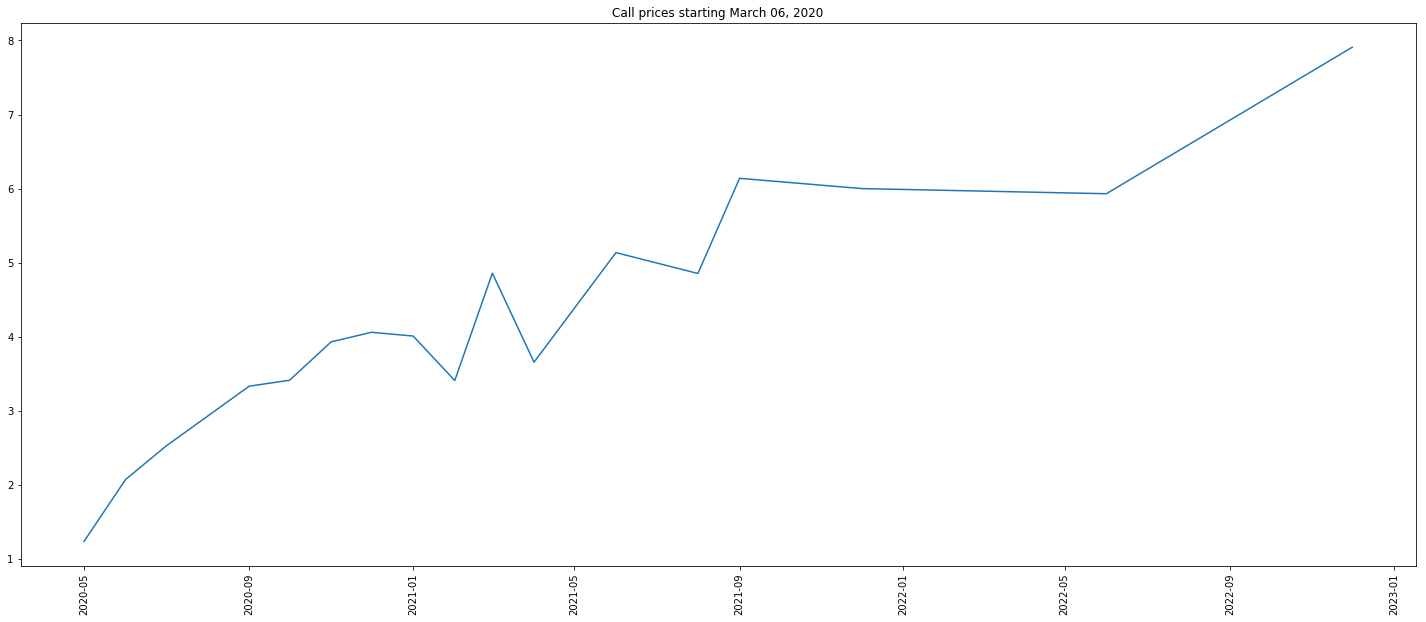

In [31]:
## For date specific Plot
#'2020-04-20'
master_wti_1=master_wti[master_wti.t =='2020-03-06']
#df_wti_1=df_wti_1[df_wti_1.begtime =='2020-11-01']
master_wti_1.set_index(master_wti_1.t, inplace=True)
master_wti_1.drop(columns="t", inplace=True)
#master_wti_1


plt.rcParams['figure.figsize'] = (25,10)
plt.plot(master_wti_1['T'],master_wti_1['call'])
plt.xticks(rotation=90)
plt.title('Call prices starting March 06, 2020')

Text(0.5, 1.0, 'Put prices starting March 06, 2020')

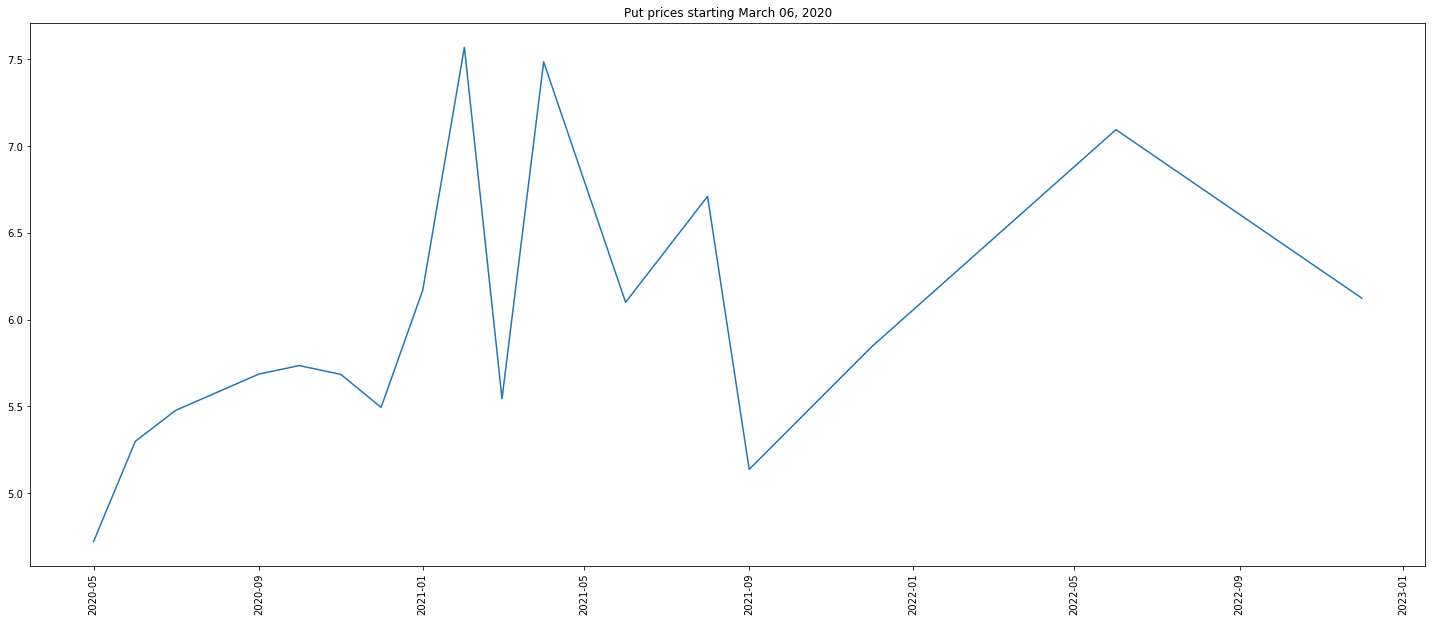

In [32]:
## For date specific Plot
plt.rcParams['figure.figsize'] = (25,10)
plt.plot(master_wti_1['T'],master_wti_1['put'])
plt.xticks(rotation=90)
plt.title('Put prices starting March 06, 2020')